# 1. Author

- Student Name: Mohammad Asghar
- Student ID: 160546576

# ECS7020P Priciples of Machine Learning - Mini-Project

## Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project. Before starting, follow these simple instructions:

1.   Go to https://drive.google.com/
2.   Create a folder named 'Machine Learning Mini Project' in 'MyDrive': On the left, click 'New' > 'Folder', enter the name **'MachineLearningMiniProject'**, and click 'create'
3.   Open the 'Data' folder and create a folder named **'MLEnd'**.


The mini-project consist of two separate components:

1.   **Basic component**: Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips.
2.   **Advanced component**: Formulate your own machine learning problem and build a machine learning solution using the MLEnd Yummy Dataset.

# 2. Problem Formulation

In this notebook, we will be working on the `Basic component`. It would be the same as done in the starter-kit. The only difference would be that instead of taking a small dataset that only contains **'Rice'** and **'Chips'** data, we will be taking the whole yummy dataset of 3250 files. The interesting aspect of this problem lies in the visual classification of food items, which can be challenging due to variations in image quality, dish presentation, and ingredients. This task is practical and relevant in food identification applications or dietary monitoring systems.

Let's start by loading a few useful Python libraries and mounting our personal Google Drive storage system (i.e. making it available, so that Colab can access it).

In [41]:
!pip install mlend

In [42]:
pip install --upgrade mlend

In [43]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy_small, yummy_small_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Machine Learning Pipeline

**Input: Images of dishes**

1. Data Preprocessing: Loading, filtering, and organizing the dataset.
2. Transformation Stage (Feature Extraction): Extracting features like color components, texture, and gray-level
   co-occurrence matrix (GLCM).
3. Modelling (Model Training): Training the RandomForestClassifier model.
4. Methodology (Model Evaluation): Evaluating the trained model using test data.

**Output: Predictions for dish categories (Rice or Chips)**.

## 3.1. Data Preprocessing

### 1. Download Data

In this section, we'll acquire the complete **MLEnd Yummy Dataset**, comprising a total of 3250 samples encompassing various dishes. Rather than utilizing `'download_yummy_small'`, we'll employ `'download_yummy'` for this purpose.

Run the next code cell to download the MLEnd Yummy Dataset.


In [44]:
import mlend
from mlend import download_yummy, yummy_load

subset = {}

datadir = download_yummy(save_to = '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


And now we can run the following cell to check the contents of the folder where the data has been uploaded.

In [45]:
os.listdir(datadir)

['MLEndYD_images',
 'MLEndYD_image_attributes_benchmark (1).gsheet',
 'MLEndYD_image_attributes_benchmark.gsheet',
 'yummy',
 'filtered_data.csv',
 'MLEndYD_image_attributes_benchmark.csv']

As you can see, there is a subfolder (`'MLEndYD_images'`) together with a CSV file (`'MLEndYD_image_attributes_benchmark.csv'`). The subfolder contains all the photos in the MLEnd Yummy dataset. The contents of this folder can be checked via Google Drive.

### 2. Understanding our dataset

Each sample in the MLEnd Yummy Dataset corresponds to one dish instance and is described by 9 attributes, namely:

- **Photo of the dish**: Image file name or identifier corresponding to the dish photo.
- **Diet**: Dietary classification indicating whether the dish is vegetarian or non-vegetarian.
- **Cuisine**: The origin or style of cuisine associated with the dish.
- **Dish name**: The name or label of the dish.
- **Whether home or restaurant**: Indicates whether the dish is prepared at home or in a restaurant.
- **Ingredients**: List of components used in preparing the dish.
- **Healthiness rating**: A subjective evaluation of the dish's healthiness level.
- **Healthiness rating in integers**: Numerical representation of the healthiness rating.
- **Likeness rating**: Subjective assessment of how much the dish is liked or preferred.
- **Likeness rating in integers**: Numerical representation of the likeness rating.
- **Benchmark_A**: Distinguishing between Train and Test Data

We can imagine the MLEnd Yummy Dataset as a table that has 3250 rows and 11 columns. Tables are a useful abstractions, but at the end of the day, we need to store the values of the attributes of each sample somewhere. Most of the attributes are text-based, and therefore can be stored using a text file, for instance, a CSV file. However, the photo attribute is a complex one that is not suitable to be stored in a text file. Consequently, we stored each photo in the separate folder *MLEndYD_images* as a JPEG file.

The CSV file *MLEndYD_image_attributes_benchmark.csv* captures the values of all the attributes of each sample. However, instead of an actual photo, this CSV file stores the name of the photo, e.g. '00001.jpg', that is stored in the separate folder *MLEndYD_images_small*.

Let's look at the contents of this CSV file.

In [46]:
import pandas as pd
import os

# Assuming MLEndYD_image_attributes_benchmark.csv contains the data
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test



We're filtering the dataframe to extract specific rows related to `'Rice'` and `'Chips or Fries'`, reducing the total rows to 881 by excluding the others. To achieve this, a new column named `'Rice_Chips'` is created and populated with *'Rice'*, *'Chips'*, or *'Both'* based on the data. To avoid confusion, rows containing *'Chips'* that refer to **'Chocolate Chips'** are also eliminated.

Additionally, we've introduced a new column in the filtered dataframe called `'Path'`, housing links directing to the image files stored in Google Drive.

In [47]:
# Adding a new column 'Rice_Chips' with default values as None
MLENDYD_df['Rice_Chips'] = None

# Function to check for 'rice' or 'chips' in a text string
def check_rice_chips(text):
    if 'rice' in text.lower() and 'fries' in text.lower() and 'chips' in text.lower():
        return 'Both'
    elif 'chocolate_chips' in text.lower():
        return 'Chocolate Chips'
    elif 'chips' and 'fries' in text.lower():
        return 'Chips'
    elif 'rice' in text.lower():
        return 'Rice'
    else:
        return None

# Applying the function to 'Dish_name' and 'Ingredients' columns to fill 'Rice_Chips'
MLENDYD_df['Rice_Chips'] = MLENDYD_df[['Dish_name', 'Ingredients']].apply(lambda x: check_rice_chips(' '.join(x)), axis=1)

# Filtering the DataFrame to include specific cases
filtered_df = MLENDYD_df[MLENDYD_df['Rice_Chips'].isin(['Rice', 'Chips'])]

# Displaying the filtered DataFrame
filtered_df

image_dir = '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/'
filtered_df['Path'] = image_dir + filtered_df.index
filtered_df

<ipython-input-47-3f8aec89d936>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips,Path
filename,,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
003236.jpg,non_vegetarian,german/turkish,german_turkish,german_doner_kebab,gdk,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",unhealthy,2.0,strongly_like,5.0,Train,Chips,/content/drive/MyDrive/MachineLearningMiniProj...
003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...


Note that there are 881 rows and 13 columns. The first column is used both as a unique indentifier (index) of the sample and also as a link to the photo of the dish. Pandas do not include the index column in the column count, and that's why it reports that the table has 13 columns.

The 12th column ('Benchmark_A') is one that we have added for benchmarking purposes. This column indicates whether a sample should be used for training or for testing. Note that no sample is included in both training and test.

The dataframe contains significantly more rows for `'Rice'` in comparison to `'Chips'`. Therefore, in this cell, we'll calculate the count for both items within the `'Rice_Chips'` column to determine the number of rows dedicated to each item.

In [48]:
import pandas as pd

# Count rows with 'Rice' under 'Rice_Chips' column
rice_count = filtered_df[filtered_df['Rice_Chips'] == 'Rice'].shape[0]

# Count rows with 'Chips' under 'Rice_Chips' column
chips_count = filtered_df[filtered_df['Rice_Chips'] == 'Chips'].shape[0]

print(f"Rows with 'Rice' under 'Rice_Chips' column: {rice_count}")
print(f"Rows with 'Chips' under 'Rice_Chips' column: {chips_count}")

Rows with 'Rice' under 'Rice_Chips' column: 801
Rows with 'Chips' under 'Rice_Chips' column: 80


Given the substantial difference in row counts between `'Rice'` and `'Chips'` with `'Rice'` being almost 10 times more prevalent — we will select 80 rows for each item. These selected rows will constitute a new dataframe specifically tailored for the machine learning pipeline.

In [49]:
# Filtered DataFrame containing 'Rice' and 'Chips'
rice_df = filtered_df[filtered_df['Rice_Chips'] == 'Rice'].head(80)
chips_df = filtered_df[filtered_df['Rice_Chips'] == 'Chips'].head(80)

# Concatenating both DataFrames
desired_df = pd.concat([rice_df, chips_df])

# Displaying the new DataFrame
desired_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips,Path
filename,,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
003159.jpg,non_vegetarian,lebanese,lebanese,ribeye_steak,restaurant,"ribeye_steak_with_garlic_sauce,fries,mixed_sal...",unhealthy,2.0,strongly_like,5.0,Train,Chips,/content/drive/MyDrive/MachineLearningMiniProj...
003187.jpg,non_vegetarian,american,american,"cheese_burger,2_wings_with_fries_and_drink",green_pepper,"regular_bun,beef,american_cheese,ketchup,chopp...",unhealthy,2.0,neutral,3.0,Train,Chips,/content/drive/MyDrive/MachineLearningMiniProj...
003220.jpg,vegetarian,british,british,chicken_with_pancakes,restaurant,"pancakes,french_fries,chicken,red_cabbage",healthy,4.0,dislike,2.0,Train,Chips,/content/drive/MyDrive/MachineLearningMiniProj...


### 3. Create Train and Test Datasets

For the basic component, we will consider the problem of predicting whether a dish has rice or chips using a picture of the dish as the predictor.

To solve this section, let us create two dataframes, one for the training task and another one for the test task. We will use the `yummy_load` function included in our `mlend` library for this, and will specify which dataframe each sample should belong to, by using the column 'Benchmark_A' in the CSV file.

In [50]:
Train_df = desired_df[desired_df['Benchmark_A'] == 'Train']
Test_df = desired_df[desired_df['Benchmark_A'] == 'Test']
Train_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips,Path
filename,,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000026.jpg,non_vegetarian,pakistani,pakistani,chicken_biryani,home,"rice,chicken,biryani_masala,yogurt,oil,green_c...",healthy,4.0,strongly_like,5.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000028.jpg,vegetarian,indian,indian,upma,home,"rice,onion,chilli,tomato,oil,pickle",healthy,4.0,neutral,3.0,Train,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
003159.jpg,non_vegetarian,lebanese,lebanese,ribeye_steak,restaurant,"ribeye_steak_with_garlic_sauce,fries,mixed_sal...",unhealthy,2.0,strongly_like,5.0,Train,Chips,/content/drive/MyDrive/MachineLearningMiniProj...
003187.jpg,non_vegetarian,american,american,"cheese_burger,2_wings_with_fries_and_drink",green_pepper,"regular_bun,beef,american_cheese,ketchup,chopp...",unhealthy,2.0,neutral,3.0,Train,Chips,/content/drive/MyDrive/MachineLearningMiniProj...
003220.jpg,vegetarian,british,british,chicken_with_pancakes,restaurant,"pancakes,french_fries,chicken,red_cabbage",healthy,4.0,dislike,2.0,Train,Chips,/content/drive/MyDrive/MachineLearningMiniProj...


In [51]:
Test_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips,Path
filename,,,,,,,,,,,,,
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000038.jpg,non_vegetarian,indian,indian,rice_with_chicken_curry,home,"boiled_rice,chicken,sunflower_oil,chilli_powde...",healthy,4.0,strongly_like,5.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000039.jpg,vegetarian,south_indian,south_indian,khichidi,home,"rice,moong_lentils,ghee,cumin_seeds,ginger",very_healthy,5.0,like,4.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000040.jpg,non_vegetarian,indian,indian,chicken_biryani,restaurant,"rice,chicken,potatos_and_spicy,",neutral,3.0,strongly_like,5.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000042.jpg,non_vegetarian,thai,thai,chicken_pad_thai,rosa's,"rice_noodles,chicken,tamarind_sauce,eggs,crush...",neutral,3.0,neutral,3.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000045.jpg,non_vegetarian,thai,thai,thai_green_curry,home,"coconut_milk,green_curry_paste,palm_sugar,fish...",very_healthy,5.0,strongly_like,5.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000056.jpg,non_vegetarian,italian,italian,rice_and_beef_meatballs,home,"beef_mince,tomato_sauce,white_long_grain_rice",healthy,4.0,like,4.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...
000058.jpg,non_vegetarian,chinese,chinese,braised_beef_brisket_on_rice,dandan_noodle_restaurant,"beef_brisket,rice,red_chillies,green_chillies,...",neutral,3.0,strongly_like,5.0,Test,Rice,/content/drive/MyDrive/MachineLearningMiniProj...


The `'Train'` dataframe comprises **104 rows**, while the `'Test'` dataframe contains **56 rows**, indicating the discrepancy in their sizes.

To generate datasets for both `'Train'` and `'Test'` data, a function is created to construct a dictionary. This dictionary includes entries for the Path (**X_paths**), `'Rice_Chips'` column encompassing both *'Rice'* and *'Chips'* dishes represented through **'Y'**, and the encoding of **'Y'** (Y_encoded). The encoding designates 'Rice' as 1 and 'Chips' as 0.

In [52]:
import numpy as np

def dataset_dictionary(df):
    dataset_dict = {
        'X_paths': df['Path'].tolist(),
        'Y': np.array(df['Rice_Chips'].tolist(), dtype=object),
        'Y_encoded': np.array(df['Rice_Chips'].apply(lambda x: 1 if x == 'Rice' else 0).tolist(), dtype=object)
    }
    return dataset_dict

Once we have defined the function, we can use it get the results dictionary using our dataframe which would include the results for all the variables **'X_paths'**, **'Y'**, & **'Y_encoded'**.

In [53]:
result_dict = dataset_dictionary(desired_df)
result_dict

{'X_paths': ['/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000001.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000016.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000020.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000021.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000022.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000026.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000028.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000035.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000038.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000039.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/

Subsequently, we'll generate the **'Train'** and **'Test'** datasets by involing the `'dataset_dictionary'` function. This function will utilize 'Train_df' as input for `'TrainSet'` and 'Test_df' for `'TestSet'`.

In [54]:
TrainSet = dataset_dictionary(Train_df)
TestSet = dataset_dictionary(Test_df)

In [55]:
TrainSet.keys()

dict_keys(['X_paths', 'Y', 'Y_encoded'])

In [56]:
TestSet.keys()

dict_keys(['X_paths', 'Y', 'Y_encoded'])

Lets plot all the labels in the training dataset using the values **'Rice'** and **'Chips'**.

In [57]:
TrainSet['Y']

array(['Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Rice', 'Rice', 'Rice', 'Chips', 'Chips', 'Chips', 'Chips',
       'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips',
       'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips',
       'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips',
       'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips',
       'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips',
       'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips',
       'Chips', 'Chips', 'Chips', 'Chips', 'Chips', 'Chips'], dtype=object)

And now, let's plot the labels encoded using the values 0 (**'Chips'**) and 1 (**'Rice'**).

In [58]:
TrainSet['Y_encoded']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

Finally, let's save the predictors and labels of the training and test dataset.

In [59]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

Y_train = TrainSet['Y_encoded']
Y_test  = TestSet['Y_encoded']

### 4. Visualising dishes

In this section, we will visualise the images that we have extracted from the `'MLEnd Yummy Dataset'`. Specifically, we will select five dishes that contain **'Rice'** and five dishes that have **'Chips'**.

Rice


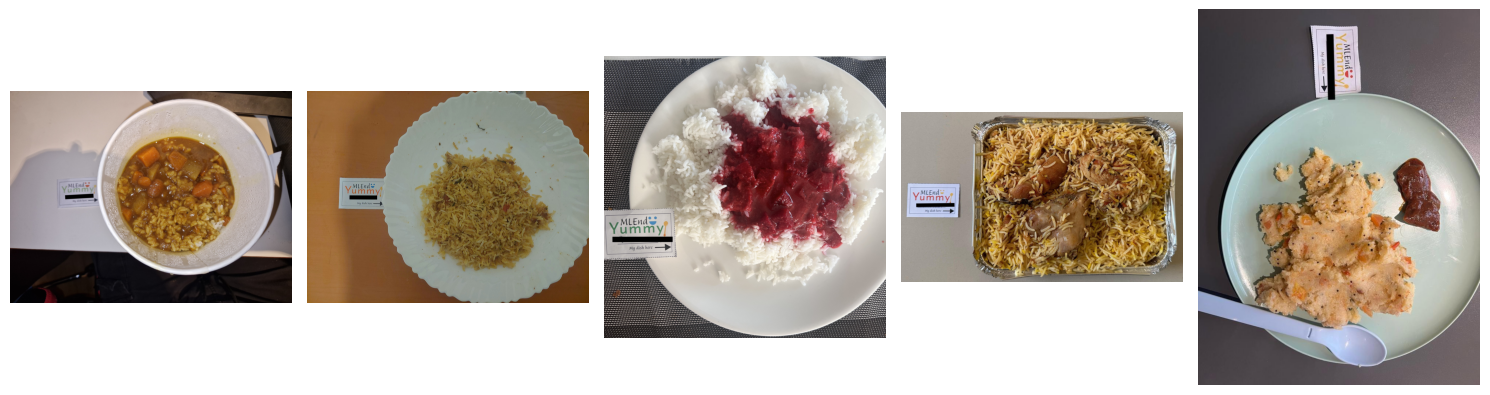

Chips


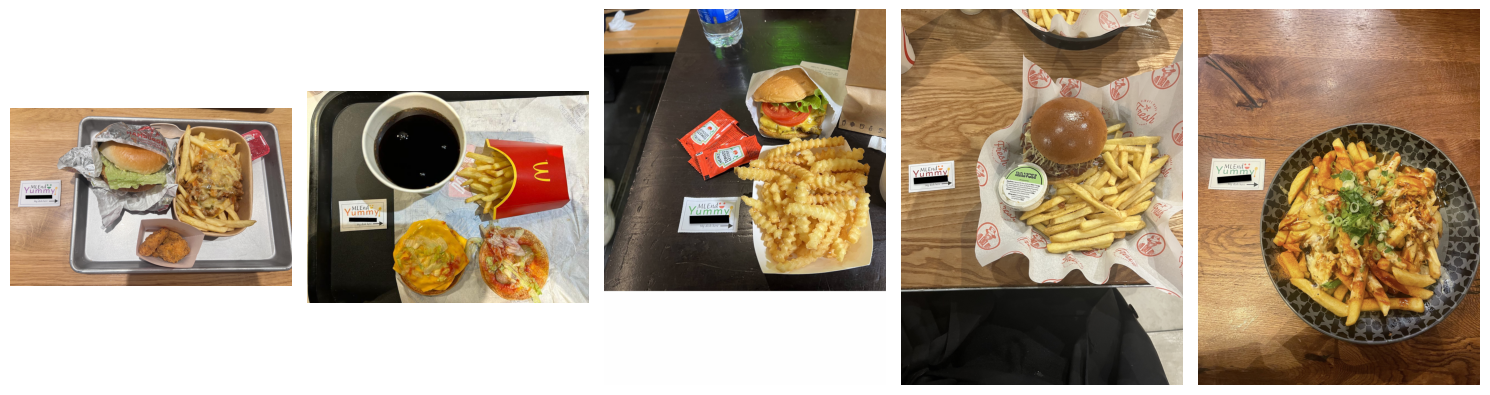

In [60]:
Chips_Img = np.array(X_train_paths)[Y_train==0]
Rice_Img = np.array(X_train_paths)[Y_train==1]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

### 5. Resizing Images

As mentioned earlier, the images vary in size. Our initial action involves resizing all images to ensure uniform dimensions. To maintain the original aspect ratio, we'll add black color to square the images. Subsequently, we'll resize them to 200 x 200 pixels.

In [61]:
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

In [62]:
X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)

X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|104\104|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|56\56|
Done!


((104, 200, 200, 3), (56, 200, 200, 3))

Now, let's plot a few images after resizing.

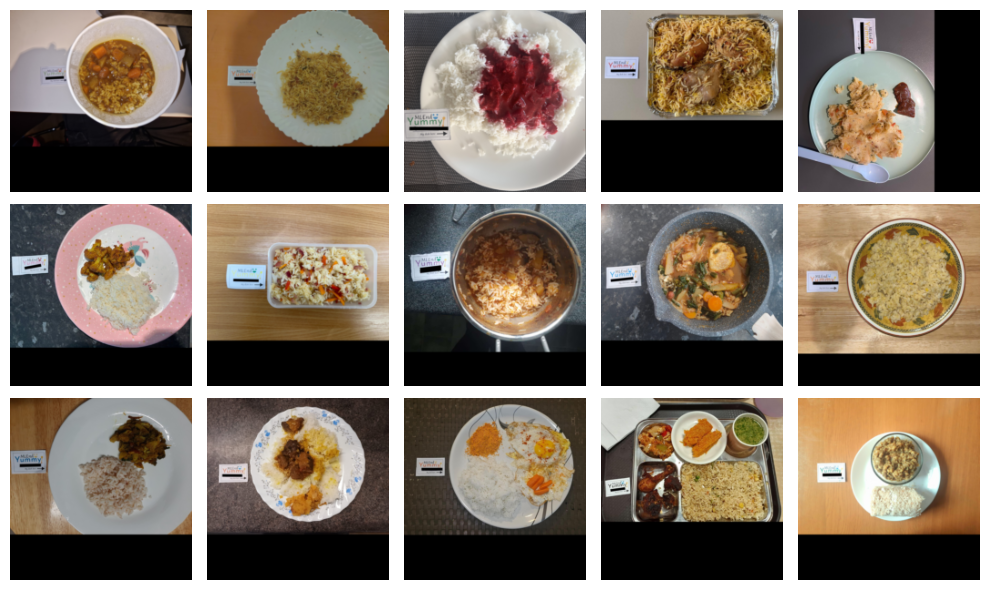

In [63]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

As you can see, all the images exhibit a square shape now, each comprising dimensions of 200 x 200 pixels.

## 3.2. Transformation Stage

- Transformation Stage: Feature Extraction
- Input: Images of dishes
- Output: Extracted features (yellow component & GLCM features)

Justification: Features like the `yellow component` to identify specific ingredients and `GLCM features` to capture texture information are chosen. These features are likely to capture important information for distinguishing between **'Rice'** and **'Chips'** dishes.

### 1. Feature Extraction

Addressing the challenge of predicting whether a dish contains **'Rice'** or **'Chips'** using 200 x 200 pixel photos as predictors necessitates addressing the dimensionality of the data. Each photo is represented by 3 x 200 x 200 = 120,000 values, resulting in a predictor space with 120,000 dimensions. For effective model training, we ideally require a training dataset comprising more than 120,000 samples. However, our current training dataset is notably smaller.

To tackle this issue, we need to reduce the dimensionality of the predictor space. In simpler terms, we aim to shift our samples from a 120,000-dimensional space to a lower-dimensional space. Feature extraction serves as a common approach to achieve this reduction in the prediction space. In the code cell below, we introduce two functions, `get_yellow_component` and `GMLC_features`, designed to extract three image features that will define a new, lower-dimensional predictor space.

In [64]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  return f1,f2


def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

Now, we'll proceed to extract the three features from each image and generate the transformation sets named `X_train_f` and `X_test_f`.

In [65]:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_train_f.append([f1,f2,f3])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_test_f.append([f1,f2,f3])

Upon formatting both `X_train_f` and `X_test_f` as numpy arrays, we can examine their respective shapes.

In [66]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((104, 3), (56, 3))

Note that `X_train_f` encompasses a dataset of 104 samples characterized by 3 attributes, while `X_test_f` consists of a set of 56 samples with 3 attributes. This stage of feature extraction has significantly reduced the dimensionality of our problem from 120,000D to 3D.

### 2. Normalisation

In addition to reducing the dimensionality of the prediction space, let's implement a normalisation stage to ensure that the 3 attributes in the new prediction space take on a similar range of values. We will implement standardisation.

In [67]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

## 3.3. Modelling

### 1. RandomForestClassifier Model

Finally, let's train and test a RandomForestClassifier model that uses the 3 normalised attributes of an image to predict whether the image corresponds to a dish that has **'Rice'** or **'Chips'**.

The `RandomForestClassifier` model demonstrates versatility in managing diverse features and excels in classification tasks, particularly when employed in ensemble learning setups. Its proficiency in handling data noise or irregularities further contributes to its effectiveness.

Let's use the `RandomForestClassifier` model available in Scikit-learn. We are using **10 decision trees** (`n_estimators`) and the **maximum depth of each decision tree is set to 5** (`max_depth`).

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Perform any necessary preprocessing on Y_train (target labels)
# For instance, if Y_train contains string labels, you can encode them into numerical values using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Create and train the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=10,max_depth=5)
model.fit(X_train_fn, Y_train_encoded)

RandomForestClassifier(max_depth=5, n_estimators=10)

## 3.4. Methodology

- **Training**: Use the training set to train the RandomForestClassifier model.
- **Validation**: Use the test set to evaluate the model's performance.
- **Performance Evaluation**: Evaluate accuracy, confusion matrix, and class-wise metrics to assess model performance.

Subsequently, employing the trained model, let's predict the labels within both the training and test datasets. Following these predictions, we'll compute the training and test accuracies based on the predicted labels.

In [73]:
ytp = model.predict(X_train_fn)
ysp = model.predict(X_test_fn)

train_accuracy = np.mean(ytp==Y_train)
test_accuracy  = np.mean(ysp==Y_test)

print('Training Accuracy:\t',train_accuracy)
print('Testing  Accuracy:\t',test_accuracy)

Training Accuracy:	 0.8942307692307693
Testing  Accuracy:	 0.6607142857142857


Different values for `n_estimators` and `max_depth` were taken for finding the accuracy after which we were able to get the optimal training and testing accuracies of **89.42%** and **66.07%**.

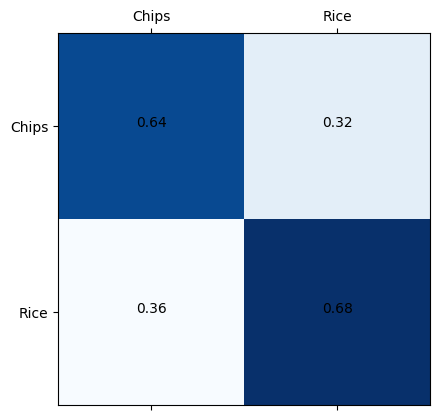

In [74]:
Ac = np.mean(ysp[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

# 4. Dataset

The MLEnd Yummy dataset is used, containing images of dishes with annotations. Preprocessing involves filtering the data, creating a subset with `'Rice'` and `'Chips'` categories, and visualizing sample images from each category.

# 5. Results

1. **Accuracies**: The `Training Accuracy` of approximately **89.42%** signifies the model's ability to predict labels correctly on the data it was trained on, indicating a good understanding of patterns within that specific dataset. However, the `Testing Accuracy` of around **66.07%** reflects a lower performance on new, unseen data, implying that the model might struggle to generalize well beyond the training dataset. This performance gap suggests potential overfitting, where the model learns from the training data excessively but fails to generalize effectively to new instances. Improving the model's capacity to generalize, possibly through techniques like hyperparameter tuning, acquiring more diverse data, or employing different modeling approaches, could enhance its ability to accurately classify rice or chips in unseen dish images.

2. **Confusion Matrix**: An accuracy of 0.68 (**68%**) for predicting rice when the actual class is also rice (`Rice Vs. Rice`) suggests the model's moderate success in identifying rice images. However, the model misclassifies rice as chips around 0.32 (**32%**) of the time (`Chips Vs. Rice`), a slightly higher error rate than misclassifying chips as rice (0.36 (**36%**), `Rice Vs. Chips`). Notably, the model shows a better accuracy of 0.64 (**64%**) for predicting chips when the actual class is chips (`Chips Vs. Chips`). These values collectively indicate that while the model performs moderately well in identifying chips, it faces challenges distinguishing rice images, possibly indicating a bias towards the more represented class or requiring refinement to better discern rice features from chips in the images.

# 6. Conclusions

The `RandomForestClassifier` exhibited moderate accuracy in discerning rice and chips dishes from images, with a Training Accuracy of **89.42%** but a lower Testing Accuracy of **66.07%**, indicating potential overfitting and difficulty in generalizing to new data. While fairly identifying rice images (**68%** accuracy in `Rice Vs. Rice`), it struggled in distinguishing rice from chips, with a higher error rate (**32%**) in misclassifying rice as chips compared to chips as rice (**36%**). With better accuracy (**64%**) in predicting chips when the actual class is chips (`Chips Vs. Chips`), the model might have a bias toward the more represented class or necessitate refinement in distinguishing rice features from chips in images. To improve classification, exploring additional features like texture, color histograms, or convolutional neural network (CNN) architectures could enhance the model's ability to differentiate between rice and chips. Experimenting with alternative models beyond RandomForestClassifier, such as Support Vector Machines (SVMs) or neural networks, might capture more intricate patterns present in dish images, potentially boosting accuracy. Moreover, fine-tuning hyperparameters, adjusting criteria like tree depth or number of estimators in the random forest, could refine the model's performance, aiding in accurate classification and better generalization.




